<a href="https://colab.research.google.com/github/hnryjsph/Training-R-CNN-with-ResNet-50/blob/main/Training_with_R_CNN_on_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FINETUNING A R-CNN with ResNet backbone for object detection of COCOCOLA BOTTLES

In [1]:
!pip install roboflow
!pip install fiftyone
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="O466H8chxDAKF7O5Yuil")
project = rf.workspace("davidbottle-defect-inspection").project("bottle-fill-level-and-cap-detec")
version = project.version(9)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bottle-fill-level-and-cap-detec-9 in coco:: 100%|██████████| 816/816 [00:00<00:00, 2592.05it/s]


In [4]:
import os
import torch
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
import numpy as np

# Define paths
dataset_path = dataset.location
ann_file = os.path.join(dataset_path, "/content/bottle-fill-level-and-cap-detec-9/train/_annotations.coco.json")
img_dir = os.path.join(dataset_path, "/content/bottle-fill-level-and-cap-detec-9/train")

# Define transforms
transform = T.Compose([
    T.ToTensor(),
])

# Load dataset
full_dataset = CocoDetection(img_dir, ann_file, transform=transform)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(project.classes) + 1  # +1 for background

# Replace head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 198MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
import torch.optim as optim
from tqdm import tqdm

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        formatted_targets = []
        for i, t in enumerate(targets):
            boxes = torch.tensor([obj["bbox"] for obj in t], dtype=torch.float32)
            boxes[:, 2:] += boxes[:, :2]  # Convert [x, y, w, h] to [x1, y1, x2, y2]
            labels = torch.tensor([obj["category_id"] for obj in t], dtype=torch.int64)
            formatted_targets.append({"boxes": boxes.to(device), "labels": labels.to(device)})

        loss_dict = model(images, formatted_targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


100%|██████████| 226/226 [01:23<00:00,  2.72it/s]


Epoch 1/5, Loss: 34.9631


100%|██████████| 226/226 [01:21<00:00,  2.78it/s]


Epoch 2/5, Loss: 16.3136


100%|██████████| 226/226 [01:20<00:00,  2.80it/s]


Epoch 3/5, Loss: 12.6124


100%|██████████| 226/226 [01:20<00:00,  2.81it/s]


Epoch 4/5, Loss: 8.7158


100%|██████████| 226/226 [01:20<00:00,  2.82it/s]

Epoch 5/5, Loss: 8.1270


In [7]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first element
            # of true_labels if it has more elements than pred_labels
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Confusion Matrix and Metrics
print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))
print("Precision:", precision_score(all_targets, all_preds, average='macro'))
print("Recall:", recall_score(all_targets, all_preds, average='macro'))
print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))
print("Accuracy:", accuracy_score(all_targets, all_preds))

100%|██████████| 114/114 [00:10<00:00, 10.71it/s]

Confusion Matrix:
 [[38  0  5  1  1]
 [ 0 23  0  4  0]
 [ 5  0 31 11  0]
 [ 0  4 11 40 14]
 [ 1  0  0 14 25]]
Precision: 0.7142982510003787
Recall: 0.7121161818617877
F1 Score: 0.713179694510389
Accuracy: 0.6885964912280702


100%|██████████| 114/114 [00:10<00:00, 10.64it/s]


Confusion Matrix:
 [[38  0  5  1  1]
 [ 0 23  0  4  0]
 [ 5  0 31 11  0]
 [ 0  4 11 40 14]
 [ 1  0  0 14 25]]
Precision: 0.7143
Recall:    0.7121
F1 Score:  0.7132
Accuracy:  0.6886


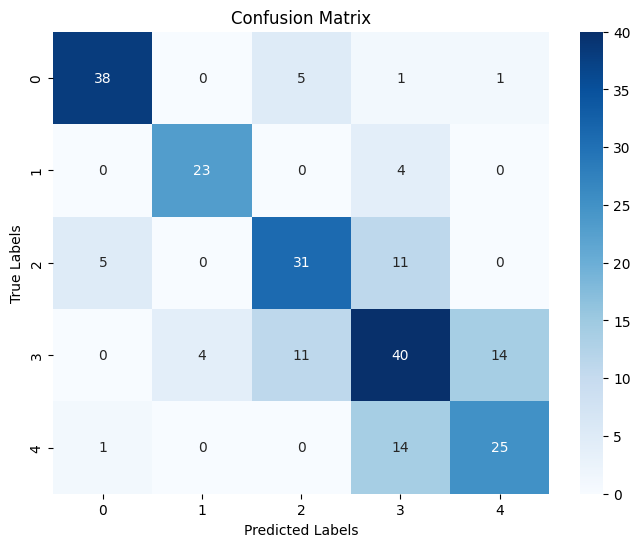

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            # Extract true labels from the list of dictionaries
            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first elements
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Compute confusion matrix and metrics
cm = confusion_matrix(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
